<a href="https://colab.research.google.com/github/Tamrika/Deep-Learning/blob/main/CNN_for_cat_vs_dog_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Image Recognition Using Convolutional Neural Networks: Cats vs Dogs Example</center>

Previously, we trained a fully connected neural network to classify cats-vs-dogs on a training dataset consisting of 1000 images of cats and 1000 images of dogs.
With careful optimization and tuning, we were able to get a 100% accuracy on the training data but only a 61% accuracy on the validation data. This showed that our fully connected network terribly overfit the training data and was not able to generalize to the validation data. Adding regularization with drop out, weight decay, and early stopping narrowd the gap between training and validation error but caused serious underfitting and did not improve the validation accuracy. There are two reasons why our fully connected network failed to generalize well to the test data:

1. The fully connected network ( in particular the first hidden layer) had over 1 million parameters which is several orders of magnitude larger than the available training data (only 2k) used to train those parameters. 
2. The fully connected network looks at each input pixel individually and is not able to extract local spatial features (such as edges,skin texture, cat or dog ears, eyes, etc.) from the image. 
As we learned in the lectures  this week, convolutional neural networks are optimized for learning spatial features from images through their local connectivity. They also share parameters between neurons in each layer, dramatically reducing the number of parameters and enabling neruons in each layer to detect same features in different parts of the image.

In this lab we revisit the cat vs dogs classification problem and try to solve it using  a CNN instead of fully connected network. Throughout this lab we will practice all the materials covered in this lecture. More specifically, this is what we do in this lab:

1. We train a baseline CNN from scratch to classify cats vs dogs. This gives us a validation accurracy of about 78-80% ( a big improvement over the fully connected network)
2. At this point, the issue would be mainly overfitting, We use data augmentation and regularization to migitgate overfitting. That will get us to validation accurracy of about 82-83%.
3. Finally, we use transfer learning and get a validation accurracy of about 97%

Together, these three strategies—training a small model from scratch, doing feature extraction using a pretrained model, and fine-tuning a pre- trained model—will constitute your future toolbox for tackling the problem of performing image classification with small datasets.
The materials covered in this lab are mostly from "Deep Learning with Python" book by Francois Chollet, chapter 5 (sections 5.2-5.3). Let's get started.

Before proceeding, at the top menu of this colab notebook select Runtime-->change runtime type--->GPU to seepd up running the code segments in the notebook.

In [ ]:
import zipfile, os
import shutil
import math
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
import tensorflow.keras.utils 








## 1. Getting and Preparing Data ( Copied from previous lab)
Let's repeat what we did in the last lab to download the data and copy it to the directory structure that can be read by ImageDataGenerator.

the next three code cells are copied from the previous lab.


In [ ]:
#Getting the Data
# downloading the files from dropbox
!wget --no-check-certificate  "https://uofi.box.com/shared/static/xvogtt25vuv0u5tzhvqttysr7ux5263i.zip" -O cats-vs-dogs.zip

#extrac the zip file downloaded
zip_ref = zipfile.ZipFile('cats-vs-dogs.zip', 'r')
zip_ref.extractall()

--2020-10-13 15:19:25--  https://uofi.box.com/shared/static/xvogtt25vuv0u5tzhvqttysr7ux5263i.zip
Resolving uofi.box.com (uofi.box.com)... 103.116.4.197
Connecting to uofi.box.com (uofi.box.com)|103.116.4.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/xvogtt25vuv0u5tzhvqttysr7ux5263i.zip [following]
--2020-10-13 15:19:26--  https://uofi.box.com/public/static/xvogtt25vuv0u5tzhvqttysr7ux5263i.zip
Reusing existing connection to uofi.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://uofi.app.box.com/public/static/xvogtt25vuv0u5tzhvqttysr7ux5263i.zip [following]
--2020-10-13 15:19:26--  https://uofi.app.box.com/public/static/xvogtt25vuv0u5tzhvqttysr7ux5263i.zip
Resolving uofi.app.box.com (uofi.app.box.com)... 103.116.4.201
Connecting to uofi.app.box.com (uofi.app.box.com)|103.116.4.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.

In [ ]:


#specify the directory where we store smaller data
base_dir = 'cats-vs-dogs_small'
#delete the directory if already exist
if(os.path.exists(base_dir)):
    shutil.rmtree(base_dir)
os.mkdir(base_dir)

#create subdirectories for train/test/validation  under the base directory
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

#create subdirectories for cat and dog under train directory
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

#create subdirectories for cat and dog under validation directory
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

#create subdirectories for cat and dog under test directory
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)



In [ ]:
original_dataset_dir="cats-vs-dogs"

#copying the first 1000 cat images to the train/cats directory
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(train_cats_dir, fname)
  shutil.copyfile(src, dst)

#copying the next 500 cats images to the validation/cats directory
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(validation_cats_dir, fname)
  shutil.copyfile(src, dst)

#copying the next 500 cats images to the test/cats directory
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_cats_dir, fname)
  shutil.copyfile(src, dst)

#copying the first 1000 dog images to the train/dogs directory
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(train_dogs_dir, fname)
  shutil.copyfile(src, dst)

#copying the next 500 dog images to the validation/dogs directory
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(validation_dogs_dir, fname)
  shutil.copyfile(src, dst)

#copying the next 500 dog images to the test/dogs directory
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
  src = os.path.join(original_dataset_dir, fname)
  dst = os.path.join(test_dogs_dir, fname)
  shutil.copyfile(src, dst)


 #Check to see if the data is copied correctly to the directory structure
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir))) 

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


We already talked about ImageDataGenerators in the previous lab
Let's repeat the following code segment from previous lab to create two generator objects one for train data and another one for validation data. Later, when we train the model, these generators read a batch of data then rescale, resize, and convert the images in the batch to tensors and run forward and backward passes on these images before the next batch is read from the disk. 

Later in this notebook, we will see that ImageDataGenerator also allow us to do image augmentation on the fly.

The following code segment is copied from the previous lab:

In [ ]:
# creating imageDataGenerator objects for train and validation data. rescale=1./255 normalizes images by dividing each pixel value by 255.
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


BATCH_SIZE=20


train_generator = train_datagen.flow_from_directory(
  #the directory to get the train data
  train_dir,
  #resize all images to 150*150
  target_size=(150, 150),
  #minibatch size 
  batch_size=BATCH_SIZE,
  #class_mode is 'binary 'for a binary classification problem (such as cat vs dogs example) or 'categorical' for a multiclass classificaiton problem
  class_mode='binary')


validation_generator = val_datagen.flow_from_directory(
    #the directory to get the train data
    validation_dir,
    #resize all images to 150*150
    target_size=(150, 150),
    #minibatch size 
    batch_size=BATCH_SIZE,
    #this is a binary classification problem, so class_mode should be binary
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# 2. Creating a Baseline Convolutional Neural Network from Scratch
Let's start with a simple model consisting of four convolutional layers, each followed by a batchnormalization layer and a maxpooling layer. Similar to VGG blocks all convolution layers use $3\times 3$ kernel size with padding one preserving the height and width of their input feature maps.

For instance, Let's look at the first convolution layer:
<code>layers.Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(150, 150, 3))</code>. 

<code>conv2D</code> means that this layer performs a convolution operation with a two dimensional kernel. <code>32</code> is the number of filters/channels used in the convolution layer, <code>(3,3)</code> is the size of each filter/kernel. <code>padding="same"</code> means we want to use a same size convolution, that is, we want to pad the input such that the output of the convolution layer has the same resolution as its input. <code>input_shape=(150, 150, 3)</code> means that the input to this layer is a 3d tensor ( $150\times150$ RGB images in this case). We only have to specify the input shape for the first convolution layer and don't need to specify it for the subsequent layers. Note that unlike the <code>Dense </code> layer, the input to <code>conv2D</code> does not need to be flattened. 

All max pooling layers use $2\times 2$ filters with stride 2, down sampling (halving) the height and width of their input feature maps.

A mentioned in the lectures, most modern CNN architectures use a global average pooling operation (GAP) at the end to partially or fully replace the stack of fully connected layers that have been traditionally used in CNN. There are two ways to incoporate GAP into a CNN:
* abondon using any fully connected layers altogether and supply the output of the GAP directly to a softmax function. This requires that the linput to GAP has as many feature maps as the number of target classes. The GAP then takes the average of each of these feature maps and send it to a softmax (or sigmoid) function for a multiclass ( or binary) classification problem.

* In the other form, one or more fully connected layers can be used along with the global average pooling layer. In this case, the input to GAP doesn't necessarily have to have the same number of feature maps as the target classes.For instance, in GoogleNet and Resnet the output of GAP is supplied to a dense layer with softmax activation.

Here we suply the output of GAP to a dense output layer. As this is a binary classificaiton problem, the output layer must have one neuron with sigmoid activation to output the probability of one class vs the other.

In keras, you can use GAP by simply adding  <code>        layers.GlobalAveragePooling2D()</code> to your network. This layes does not have any parameter.


we start with 32 channels for the first convolution layer and double the number of channels after each max pooling layer (except for the last layer where we keep the number of channels at 128). 

In almost all CNN architectures you see that the number of channels progressively increase as we go layer by layer while the height and width of the feature maps decrease.

It is also common to use Batchnormalization in each convolution layer to speed up learning and improve generalization.

We create a function build_baseling that configures the network architecture  then compiles and returns the model.


In [ ]:

#Configuring the model architecture
def build_baseline():
  model=keras.Sequential(
    [
        # first convolution layer + max pooling layer  
        layers.Conv2D(32, (3, 3), activation='relu', padding="same",input_shape=(150, 150, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
                # second convolution layer + max pooling lyaer
        layers.Conv2D(64, (3, 3), padding="same", activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # third convolution layer + max pooling lyaer
        layers.Conv2D(128, (3, 3), padding="same",activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # fourth convolution layer + max pooling layer
        layers.Conv2D(128, (3, 3), padding="same",activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        #A global average pooling layer
        layers.GlobalAveragePooling2D(),
        

        # A Dense output layer with sigmoid activation   
        layers.Dense(1, activation='sigmoid')
    ])
  
# compliling model
  
  #create a learning_rate schedule
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9)

  #configuring and compiling the model
  opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
  model.compile(loss="binary_crossentropy", metrics=['accuracy'], optimizer=opt)

  #returning the model 
  return model

model=build_baseline()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       7

As you can see this CNN has only 242.3K parameters which are several orders of magnitude smaller than a fully connected network. 

Let's go ahead and train this model on the training data and use validation set to evaluate it. Note that we use Early stopping to stop the training if validation accurracy does not improve by at least 0.1% in 10 epochs.

After the model is trained we can save it in the disk using <code>model.save</code>. This will allow us to later laod the trained model from the disk if we need to do inference. When running this in google colab, it will save it for the current active session. If you want to save it permanently, click on the "Files" pannel on the right, find the saved model and download it to your local machine or save it on your google drive.


In [ ]:
#callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=1e-3, restore_best_weights=True)

#start the training
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = math.ceil(2000/BATCH_SIZE) ,
            epochs = 50,
            validation_steps = math.ceil(1000/BATCH_SIZE),
            callbacks=callback,
            verbose = 1)
model.save("cas-vs-dogs-baseline.h5")

Epoch 1/50
100/100 [==============================] - 9s 94ms/step - loss: 0.5922 - accuracy: 0.6930 - val_loss: 1.2408 - val_accuracy: 0.5000
Epoch 2/50
100/100 [==============================] - 9s 94ms/step - loss: 0.5673 - accuracy: 0.7090 - val_loss: 0.8574 - val_accuracy: 0.5010
Epoch 3/50
100/100 [==============================] - 9s 93ms/step - loss: 0.5324 - accuracy: 0.7405 - val_loss: 0.8736 - val_accuracy: 0.5070
Epoch 4/50
100/100 [==============================] - 9s 95ms/step - loss: 0.5158 - accuracy: 0.7530 - val_loss: 0.7490 - val_accuracy: 0.5570
Epoch 5/50
100/100 [==============================] - 9s 92ms/step - loss: 0.4996 - accuracy: 0.7670 - val_loss: 0.6182 - val_accuracy: 0.6430
Epoch 6/50
100/100 [==============================] - 9s 93ms/step - loss: 0.4733 - accuracy: 0.7840 - val_loss: 0.6228 - val_accuracy: 0.6850
Epoch 7/50
100/100 [==============================] - 9s 94ms/step - loss: 0.4774 - accuracy: 0.7755 - val_loss: 0.5203 - val_accuracy: 0.7430

Using a small CNN, we were able to get the validation accurracy up to 78-79% which is a big improvement over a fully connected network. Let's take a look at the learning curves for training and validation.

Note that due to random weight initialization, you might get a slightly different results.

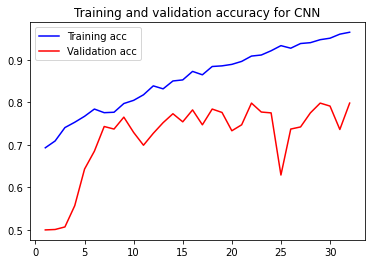

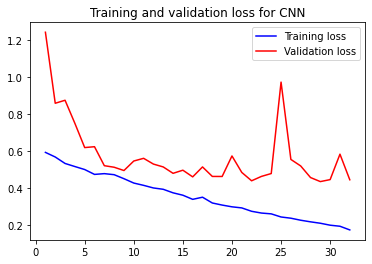

In [ ]:

#getting train and validation accuracies
train_acc_CNN = history.history['accuracy']
val_acc_CNN = history.history['val_accuracy']

#getting train and validation losses
train_loss_CNN = history.history['loss']
val_loss_CNN = history.history['val_loss']
epochs = range(1, len(train_loss_CNN) + 1)

#plotting the training and validation accurracies
plt.plot(epochs, train_acc_CNN, 'b', label='Training acc')
plt.plot(epochs, val_acc_CNN, 'r', label='Validation acc')
plt.title('Training and validation accuracy for CNN')
plt.legend()
plt.figure()

#plotting the train and validaiton losses
plt.plot(epochs, train_loss_CNN, 'b', label='Training loss')
plt.plot(epochs, val_loss_CNN, 'r', label='Validation loss')
plt.title('Training and validation loss for CNN')
plt.legend()

plt.show()

Theses plots show severe overfitting. The training accurracy increases consistently over time until it reaches 96% whereas the validation accurracy stalls at around 78-79%. The validation loss reaches its minimum after only 8 epochs then stalls whereas the training loss keeps decreasing linearly until it reaches nearly 0.

Because you have relatively few training samples (2,000) compared to the number of parmeters, overfitting will be your number-one concern. You already know about a number of techniques that can help
mitigate overfitting, such as dropout and weight decay (L2 regularization). 

Dropout is typically not used with convolutional layers because, due to parameter sharing, these layer are less prone to overfitting. Dropout is typically more effective if it is used between fully connected/Dense layers. In the network we designed here, there is no dense layer except the output layer and, as was explained in the previous module, we should never apply drop out to the output layer.

In the next section, we use data augmentation as one of the most powerful regularization technique specific to computer vision. Data augmentation is used almost universally when processing images with deep-learning models.

# 4. Using Data Augmentation
recall that the first thing recommended to improve generalization in the lectures ( and in Goodfellow's deep learning book) was to get more data. Overfitting is caused by having too few samples to learn from making it difficult (if not impossible) to train a model that can generalize to new data. Given infinite data, your model would be exposed to every possible aspect of the data distribution and you would never overfit. In real world; however, we always have limited training data and hence, our models are likely to overfit.

In this example, we only used 10% of the training examples in Kaggle. We can use the entire kaggle dataset to improve generalization. However, in many real world problems we may not have access to more data. As we discussed in the lectures, data augmentation is a very effective method to improve generalization in particular, in image recognition problems. 

In Keras, image augmentation can be done by configuring a number of random transformations to
be performed on the images read by the <code>ImageDataGenerator</code> instance. Images are read in batches, then a random transformation is performed on the fly to each image. 

You can refer to [tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) for a complete list of transformation that can be done using <code>ImagedataGenerator</code>.  The transofmrations we used in the code segment below are:
- rotation: the <code>rotation_range</code> is a value in degrees (0–180), a range within which to randomly rotate pictures.
- shifting: <code>width_shift</code> and <code>height_shift</code> are ranges (as a fraction of total width or height) within which to randomly shift pictures vertically or horizontally.
- shear:  A transformation that slants an image in a particular direction. <code>shear_range</code> is for randomly applying shearing transformations.
- zooming: <code>zoom_range</code> is for randomly zooming inside pictures.
- flipping: <code>horizontal_flip</code> is for randomly flipping half the images horizontally.

Data augmentatio can be applied both on the training set during training and on the test set during inference/prediction. Here we apply the data augmentation to the training data to let model learn to be invariant to various image transformations and avoid overfitting.  

![imageaugmentation](https://drive.google.com/uc?export=view&id=1Xs3-_F6ev8rBCoOGL75l6yWULNd8RGjB)

*image source: Deep Learning with Python, Chollet (chapter 5, figure 5.11)*



In [ ]:

#re-define the train_datagen with data augmentation
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
  #the directory to get the train data
  train_dir,
  #resize all images to 150*150
  target_size=(150, 150),
  #minibatch size 
  batch_size=20,
  #class_mode is 'binary 'for a binary classification problem (such as cat vs dogs example) or 'categorical' for a multiclass classificaiton problem
  class_mode='binary')



Found 2000 images belonging to 2 classes.


Ok. Now let's rebuild and recompile the baseline model and fit it to the new train_generator with data augmentation then plot the learning curve.

In effect, data augmentation adds some noise to the data . In each iteration the ImageGenerator selects a batch of images and randomly transform each image in the bactch before feeding it to the network so the network never sees the same image twice but the images it sees are still heavily intercorrelated, because they come from a small number of original images—you can’t produce
new information, you can only remix existing information. As such, this may not
be enough to completely get rid of overfitting. 

Because we are adding noise, we need to train the network longer. I increased the number of epochs to 100. 

In [ ]:
model= build_baseline()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, min_delta=1e-3, restore_best_weights=True)
BATCH_SIZE=20
#start the training
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = math.ceil(2000/BATCH_SIZE) ,
            epochs = 100,
            validation_steps = math.ceil(1000/BATCH_SIZE),
            callbacks=callback,
            verbose = 1)


Epoch 1/100
100/100 [==============================] - 17s 173ms/step - loss: 0.6695 - accuracy: 0.6005 - val_loss: 0.7311 - val_accuracy: 0.5000
Epoch 2/100
100/100 [==============================] - 17s 173ms/step - loss: 0.6273 - accuracy: 0.6545 - val_loss: 0.7722 - val_accuracy: 0.5000
Epoch 3/100
100/100 [==============================] - 17s 172ms/step - loss: 0.6119 - accuracy: 0.6605 - val_loss: 0.9351 - val_accuracy: 0.5000
Epoch 4/100
100/100 [==============================] - 18s 177ms/step - loss: 0.5941 - accuracy: 0.6780 - val_loss: 0.7582 - val_accuracy: 0.5210
Epoch 5/100
100/100 [==============================] - 17s 174ms/step - loss: 0.5857 - accuracy: 0.6945 - val_loss: 0.6851 - val_accuracy: 0.5700
Epoch 6/100
100/100 [==============================] - 18s 178ms/step - loss: 0.5708 - accuracy: 0.6980 - val_loss: 0.5590 - val_accuracy: 0.7160
Epoch 7/100
100/100 [==============================] - 18s 177ms/step - loss: 0.5648 - accuracy: 0.7150 - val_loss: 0.5909 -

Let's plot the learning curves.


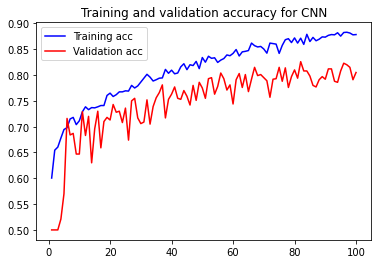

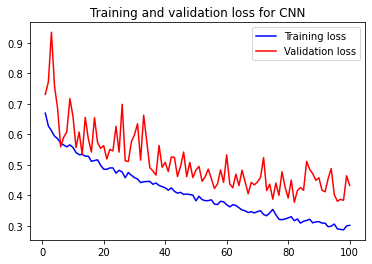

In [ ]:

#getting train and validation accuracies
train_acc_CNN = history.history['accuracy']
val_acc_CNN = history.history['val_accuracy']

#getting train and validation losses
train_loss_CNN = history.history['loss']
val_loss_CNN = history.history['val_loss']
epochs = range(1, len(train_loss_CNN) + 1)

#plotting the training and validation accurracies
plt.plot(epochs, train_acc_CNN, 'b', label='Training acc')
plt.plot(epochs, val_acc_CNN, 'r', label='Validation acc')
plt.title('Training and validation accuracy for CNN')
plt.legend()
plt.figure()

#plotting the train and validaiton losses
plt.plot(epochs, train_loss_CNN, 'b', label='Training loss')
plt.plot(epochs, val_loss_CNN, 'r', label='Validation loss')
plt.title('Training and validation loss for CNN')
plt.legend()

plt.show()

The learning curves look much better than before. We still see overfitting but the validation loss is much closer to the training loss than before and the gap is reduced. it appears that both the training and validation accuracies still have upward trends which suggest that we might gain performance by continue training the model for more epochs.

 Let's continue training the model for another 100 epochs. To do this, we don't redefine/reinitialize the model and just call model.fit to let it run for few more epochs. 


In [ ]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = math.ceil(2000/BATCH_SIZE) ,
            epochs = 100,
            validation_steps = math.ceil(1000/BATCH_SIZE),
            callbacks=callback,
            verbose = 1)

Epoch 1/100
100/100 [==============================] - 17s 173ms/step - loss: 0.2823 - accuracy: 0.8945 - val_loss: 0.4413 - val_accuracy: 0.7990
Epoch 2/100
100/100 [==============================] - 17s 172ms/step - loss: 0.2907 - accuracy: 0.8800 - val_loss: 0.3902 - val_accuracy: 0.8200
Epoch 3/100
100/100 [==============================] - 17s 170ms/step - loss: 0.2785 - accuracy: 0.8995 - val_loss: 0.4454 - val_accuracy: 0.8080
Epoch 4/100
100/100 [==============================] - 17s 169ms/step - loss: 0.2732 - accuracy: 0.8955 - val_loss: 0.4323 - val_accuracy: 0.8090
Epoch 5/100
100/100 [==============================] - 17s 170ms/step - loss: 0.2859 - accuracy: 0.8850 - val_loss: 0.4037 - val_accuracy: 0.8170
Epoch 6/100
100/100 [==============================] - 17s 170ms/step - loss: 0.2854 - accuracy: 0.8875 - val_loss: 0.4180 - val_accuracy: 0.8050
Epoch 7/100
100/100 [==============================] - 18s 176ms/step - loss: 0.2916 - accuracy: 0.8745 - val_loss: 0.3855 -

We were able to increase  the validation accurracy slightly to 83% after that both training and validation accurracies start to plateau.

As a next step to improve your accuracy on this problem, you’ll have to use a pretrained model, which is the focus of the next two sections

# 5. Transfer Learning: Using a Pre-trained model
A common and highly effective approach to deep learning on small image datasets is to use a pretrained network. A pretrained network is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. If this original dataset is large enough and general enough, then the spatial hierarchy of features learned by the pretrained network can effectively act as a generic model of the visual world, and hence its features can prove useful for many different computer vision problems, even though these new problems may involve completely different classes than those of the original task.

In this case, let’s consider a large convnet trained on the ImageNet dataset(1.4 million labeled images and 1,000 different classes). ImageNet contains many animal classes, including different species of cats and dogs, and you can thus expect to perform well on the dogs-versus-cats classification problem.


## 5.1 Feature Extraction
As explained in the lectures, we can take the convolutional base (convolutional layers + possibly batchnorm layers) of a well known architecture (such as VGG, ResNet, Inception, DenseNet etc.) pretrained on ImageNet, run the new dataset through it to extract features and train a new classifier with these features.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges, colors, and textures), whereas layers that are higher up
extract more-abstract concepts (such as “cat ear” or “dog eye”). So if your new dataset
differs a lot from the dataset on which the original model was trained on, you may be better off using only the first few layers of the model to do feature extraction, rather than using the entire convolutional base. In this cases since the cat vs dog dataset is similar to the type of images in ImageNet, we will use the whole convolutional base.

For this lab, we are going to use DenseNet121 architecture trained on ImageNet. The DenseNet121 model, among others, comes prepackaged with Keras. You can import it from the keras.applications module. Check [tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications) for the list of image-classification models (all pretrained on the ImageNet dataset) that are available as part of keras applications.

You pass three arguments to the constructor: 
- *weights*: specifies the weight checkpoint from which to initialize the model.
- *include_top*: refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because we intend to use our own densely connected classifier (with only two classes: cat and dog ), we don’t need to include it.
- *input_shape* is the shape of the image tensors that you’ll feed to the network.

Before you compile and train the model, it is very important to freeze the convolutional base. **Freezing a layer or set of layers means preventing their weights from being updated during training**. If you don’t do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned. Weights are freezed by setting <code>conv-base.trainable=False</code>

In [ ]:


#instantiate a DenseNet121 model trained on ImageNet dataset
from tensorflow.keras.applications import DenseNet121
conv_base = DenseNet121(weights='imagenet',
include_top=False,
input_shape=(150, 150, 3))

#freeze the weight of the convolutional base
conv_base.trainable=False

# get the summary of the model to view its architecture
conv_base.summary()


29089792/29084464 [==============================] - 1s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 75, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1/conv[0][0]                 
_______________________

We can see that the convolutional base of DenseNet121 has about 7 million parameters. Since the weights are frozen, none of these parameters are trainable. 

Now we can stack our own classifier on top of DenseNets' convolution base. We are going to use *Keras Functional API* isntead of *Sequential API* to build our model. So before building our model, let's talk a little about Keras functional API.

### What is Keras Functional API?

So far we used "sequential" API to stack models on top of one another. The sequential API makes the assumption that the network has exactly one input and one output and that it consists of stacks of layers. Although *sequential API" is sufficient for many simple networks, these assumptiosn are too inflexible for many recently developed architecture.  For instance, the inception block in GoogleNet (slide 49) requires the output of multiple layers to be concatenated and Resnet  (slide 53) has internal branching between layers  that makes it look more like graphs of layers rather than linear stacks of layers. There are many other examples of such graph like networks.


Some tasks, for instance, require multimodal inputs: they merge data coming from
different input sources, processing each type of data using different kinds of neural layers. Imagine a deep-learning model trying to predict the most likely market price of a second-hand piece of clothing, using the following inputs: user-provided metadata (such as the item’s brand, age, and so on), a user-provided text description, and a picture of the item. If you had only the metadata available, you could one-hot encode it and use a densely connected network to predict the price. If you had only the text description available, you could use an RNN or a 1D convnet. If you had only the picture,
you could use a 2D convnet. But how can you use all three at the same time? A
naive approach would be to train three separate models and then do a weighted average of their predictions. But this may be suboptimal, because the information extracted by the models may be redundant. A better way is to jointly learn a more accurate model of the data by using a model that can see all available input modalities simultaneously: a model with three input branches ( see figure below from "deep learning with python, chapter 7)

![multimodel input](https://drive.google.com/uc?export=view&id=1iZygRcBPYrzGvA--COvFDzYLjfYvh8FI)

These three important use cases—multi-input models, multi-output models, and
graph-like models—aren’t possible when using only the Sequential model class in
Keras. But there’s another far more general and flexible way to use Keras: the functional API.

In the functional API, you directly manipulate tensors, and you use layers as functions that take tensors and return tensors (hence, the name functional API). For instance,

<code>
dense_1_output_tensor=layers.Dense(64, activation="sigmoid") (input_tensor)</code>

Is a dense layer that takes an input tensor and returns an input tensor.

Definining the layers this way, gives the flexibility to implement networks with complex internal topolog as a directed acyclic graph of layers.  The
qualifier *acyclic* is important: these graphs can’t have cycles. It’s impossible for a tensor x to become the input of one of the layers that generated x. 

Once you are done creating your layers, you can define the model by specifying its input and output tensors using:
<code>Model(inputs=[a list of inputs], output=[a list of outputs]
</code>

You can also plot the model to see its graph using <code>plot_model</code> function.

To illustrate the functional API consider a hypothetical network where Foan input tensor goes to two convolution layers with different filter sizes, and their output is concatenated and sent to a dense layer which then gives the final output of the network. We can use the functional API as follows to define this hypothetical network. The plot of the network is also shown.





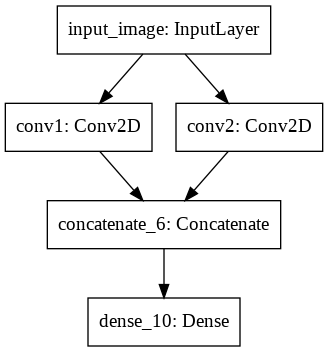

In [ ]:
# create a hypothetical non-linear model to illustrate functional API

# create an input layer/tensor
input= layers.Input(shape=(150, 150, 3), dtype="float32", name="input_image")

#create two convolutional layers with different filter sizes taking the same input tensor
conv1=layers.Conv2D(128, (5, 5), padding="same",activation='relu', name="conv1")(input)
conv2=layers.Conv2D(128, (3, 3), padding="same",activation='relu', name="conv2")(input)

#concatenate the output of the two convolution layers
concat=layers.concatenate([conv1,conv2], axis=-1 )

#create the dense layer that takes the concatenated output
output_dense=layers.Dense(10, activation="softmax")(concat)

#create a model that takes the input tensor as input and gives the output of the dense layer as output
hypothetical_model = Model(input, output_dense)

#plot the model
tf.keras.utils.plot_model(hypothetical_model)

### Back to feature Extraction 

Now let's go back to feature extraction for using a pre-trained network for cat-vs-dog problem.

 We can create a model by stacking our own classifier (consisting of an average pooling layer (GAP) plus the output layer) on top of the convolutional base of DenseNet. You could optionally add one or more fully connected layer after the GAP layer but for this problem, since the cat vs dog dataset has similar type of images as imagenet, we get a good performance even without adding dense layers at the top.  

We are going to use Keras functional to build a model consisting of the conv_based and the top classifier.  


In [ ]:

#initialize the topclassifier to the output of the convolutional base of densenet
topClassifier = conv_base.output

#Adding the global average pooling (GAP)layer on top of conv_base 
topClassifier=layers.GlobalAveragePooling2D()(topClassifier)

#adding a dense layer on top of GAP layer to do the classification
topClassifier = layers.Dense(1, activation="sigmoid")(topClassifier)

model = Model(inputs=conv_base.input, outputs=topClassifier)

model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 75, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________

As you can seee the layers of the top classifier was added on top of the convolution based of densenet. The combined model has over 7 million parameters but only 1025 of them are trainable. These are the parameters for the top classifier. The parameters of conv_base are frozen ( they don't get updated by training the model on cat-vs-dog dataset). More specifically, all 1025 trainable parameters belong to the last dense layer (output layer). The GAP layer does not have any  parameter. 

Now we compile and fit the model as usual. Then draw the learning curves

In [ ]:
#create a learning_rate schedule

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9)

#configuring and compiling the model
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss="binary_crossentropy", metrics=['accuracy'], optimizer=opt)

#callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=1e-3, restore_best_weights=True)

#start the training
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = math.ceil(2000/BATCH_SIZE) ,
            epochs = 30,
            validation_steps = math.ceil(1000/BATCH_SIZE),
            callbacks=callback,
            verbose = 1)

Epoch 1/30
100/100 [==============================] - 20s 203ms/step - loss: 0.7792 - accuracy: 0.5790 - val_loss: 0.5371 - val_accuracy: 0.7500
Epoch 2/30
100/100 [==============================] - 18s 184ms/step - loss: 0.5202 - accuracy: 0.7425 - val_loss: 0.3329 - val_accuracy: 0.8720
Epoch 3/30
100/100 [==============================] - 18s 183ms/step - loss: 0.3996 - accuracy: 0.8125 - val_loss: 0.2502 - val_accuracy: 0.9120
Epoch 4/30
100/100 [==============================] - 18s 184ms/step - loss: 0.3338 - accuracy: 0.8500 - val_loss: 0.2058 - val_accuracy: 0.9270
Epoch 5/30
100/100 [==============================] - 18s 185ms/step - loss: 0.2941 - accuracy: 0.8730 - val_loss: 0.1768 - val_accuracy: 0.9390
Epoch 6/30
100/100 [==============================] - 18s 184ms/step - loss: 0.2795 - accuracy: 0.8745 - val_loss: 0.1590 - val_accuracy: 0.9460
Epoch 7/30
100/100 [==============================] - 18s 181ms/step - loss: 0.2607 - accuracy: 0.8825 - val_loss: 0.1461 - val_ac

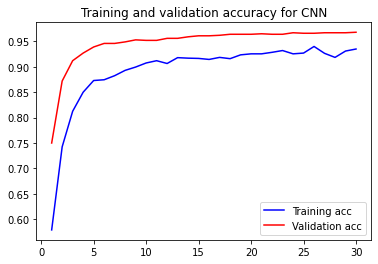

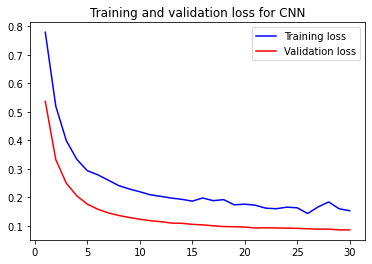

In [ ]:

#getting train and validation accuracies
train_acc_CNN = history.history['accuracy']
val_acc_CNN = history.history['val_accuracy']

#getting train and validation losses
train_loss_CNN = history.history['loss']
val_loss_CNN = history.history['val_loss']
epochs = range(1, len(train_loss_CNN) + 1)

#plotting the training and validation accurracies
plt.plot(epochs, train_acc_CNN, 'b', label='Training acc')
plt.plot(epochs, val_acc_CNN, 'r', label='Validation acc')
plt.title('Training and validation accuracy for CNN')
plt.legend()
plt.figure()

#plotting the train and validaiton losses
plt.plot(epochs, train_loss_CNN, 'b', label='Training loss')
plt.plot(epochs, val_loss_CNN, 'r', label='Validation loss')
plt.title('Training and validation loss for CNN')
plt.legend()

plt.show()

As you can see, Using trainsfer learning, we have reached a validation
accuracy of about 96%. This is much better than were able to achieved in the previous sections with the small convnet trained from scratch.

The learning curves are much more smooth and the model is no longer overfitting ( validation accurracy is slightly higher than the train accurracy). You might be surprised to see a network with a higher training loss than the validation loss. This is because DesenNet uses drop out layers and it is common to see such pattern when we use dropout since drop out adds some noise during trianing ( randomly turns off some neurons) in order to increase model robustness and generalization. At the validation time though the drop out is not applied and hence if the network is not overfitting, the valdiation loss might end up being lower than the training loss as we see in the learning curves above.

## Fine Tuning

Once feature extraction is done and our newly added top classifier was trained on our target dataset (cat-vs-dog), we can unfreez some of the later convolutional layers in the pretrained network in order to make them more relevant for the problem at hand.

Why don't we unfreez all the layers in the pretrained network? Well as we said before, the convolutional layers that come earlier in the pre-trained model extract local, highly generic feature maps (such as visual edges, colors, and textures) whereas layers that are higher up in the convolutional base extract more-abstract concepts (such as “cat ear” or “dog eye”) specific to the problem. therefore, it makes sense to unfreez some of the top convolution layers and train them some more on our target dataset. 

Note that **fine tuning must be done after feature extraction is completed** Otherwise, if the top classifier is not already trained on the target data, the error signals propagating through the network during training will be too large, and the representations previously learned by the layers being fine-tuned will be destroyed.

So here are the steps for fine tuning:
* Do Feature Extraction as you did in the previous section to train the top classifier on the traget dataset
* Unfreez some of the top convolution layers in the pretrained network and train it on the target dataset. 

Note that when we unfreez some layers in the pretrained network, we are NOT randomly initializing their weights/parameters but their weights are already learned on the pretrained dataset ( ImageNet for instance) and we are only adjusting them by training the network for a few iterations on the target dataset (cats-vs-dogs int this case) 

Doing fine tuning in Keras is straightforward.We first make the conv_base model trainable by setting <code>conv_base.trainable</code> to true. Then we loop over each layer in conv_base and set <code>layer.trainable</code> to true if we want to tune that layer; otherwise we set it to false.

Looking at the architecture of DenseNEt121 in the previous section, let's tune the last convolutional block ( that is, the last 9 layers in the conv_base).



In [ ]:

#unfreez the convolution base
conv_base.trainable = True

#set trainable to False for all layers except the last 9 , that is freeze the weights for all layers except the last 9 layers
for layer in conv_base.layers[:-9]:
    layer.trainable=False

#set trainable to True for the last 9 layers ( the last convolutional block in DENSENET121). That is unfreez the weights for the last 9 layers
for layer in conv_base.layers[-9:]:
    layer.trainable=True

 


we also should use a very low learning rate when we do fine tuning because we want to limit the magnitude of the modifications we are  making to the representations of the conv layers we are fine-tuning. Updates that are too large may harm these representations. I also increase the number of epochs and set  patience=20 in early stopping callback to allow the model to be trained for more iterations.



In [ ]:
 
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, min_delta=1e-3, restore_best_weights=True)


model.compile(loss="binary_crossentropy", metrics=['accuracy'], optimizer=opt)

#Tune the model by fittig it for some more iterations to cat-vs-dog dataset
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = math.ceil(2000/BATCH_SIZE) ,
            epochs = 100,
            validation_steps = math.ceil(1000/BATCH_SIZE),
            callbacks=callback,
            verbose = 1)


Epoch 1/100
100/100 [==============================] - 20s 201ms/step - loss: 0.2023 - accuracy: 0.9210 - val_loss: 0.1001 - val_accuracy: 0.9630
Epoch 2/100
100/100 [==============================] - 19s 186ms/step - loss: 0.2048 - accuracy: 0.9190 - val_loss: 0.1024 - val_accuracy: 0.9660
Epoch 3/100
100/100 [==============================] - 18s 185ms/step - loss: 0.1978 - accuracy: 0.9260 - val_loss: 0.1011 - val_accuracy: 0.9700
Epoch 4/100
100/100 [==============================] - 19s 187ms/step - loss: 0.2068 - accuracy: 0.9140 - val_loss: 0.0991 - val_accuracy: 0.9720
Epoch 5/100
100/100 [==============================] - 19s 187ms/step - loss: 0.1872 - accuracy: 0.9290 - val_loss: 0.0977 - val_accuracy: 0.9700
Epoch 6/100
100/100 [==============================] - 18s 183ms/step - loss: 0.1951 - accuracy: 0.9270 - val_loss: 0.0959 - val_accuracy: 0.9700
Epoch 7/100
100/100 [==============================] - 18s 182ms/step - loss: 0.1983 - accuracy: 0.9200 - val_loss: 0.0942 -

Looks like we got a little less than one percent performance gain by fine tuning the model. 

Let's also save the trained model to disk so we can load it later if we need it. The model will be saved in your google colab session and will no longer be available once the session is terminated. You can download it in to your local machine or google drive to save it permanently.

In [ ]:
#savng the modle on disk
model.save("cats-vs-dogs-finetuned.h5")

## Showing missclassified images in the validaiton data

*   List item
*   List item


Let's take a look at the images that were missclassified in the validation data.
The following code segment goes through every batch of images in the validation_generator, get model predictions, find the images that were missclassified in the batch and displays them together with their predicted probabilities.


In [ ]:

#create a dictionary for label names. "dog" images are labled as 1, cat images are labeled as zerp.
names={1:"dog",0:"cat"}


batch_index=0
#Get each batch of images in the validation generator (x is  the image, y is its true label)
for x,y in validation_generator:
    if batch_index>math.ceil(1000/BATCH_SIZE):
        break;
    # Get the predicted probabilities for the images in the batch. It will return a numpy array of size 1*batch_size, so flatten it to a vector
    y_pred = model.predict(x).flatten()
    
    # If a predicted probability for an image is >0.5, set the predicted label to 1 otherwise to zero
    y_pred_label=np.where(y_pred>0.5,1.,0.)
    
    #get the indices of the missclassified images in the batch
    errors = np.where(y_pred_label != y)[0]
    
    #display the missclassified images together with their predicted probabilities
    for i in errors:
        print("True label is: {}, CNN predicted {} with confidence {}".
             format(names[y[i]],names[y_pred_label[i]], y_pred[i] if y_pred_label[i]==1.0 else 1-y_pred[i]))
        plt.imshow(x[i])
        plt.show()
        
    #get the next batch
    batch_index=batch_index+1
    

# 6. Computing the accuracy on the test data

Now that we are happy with the validaiton performance of the model, let's go ahead and compute its accurracy on the test data

In [ ]:
test_dir = os.path.join(base_dir, 'test')

#read the test images using ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

#compute the loss and accurracy on the test set using model.evaluate method
test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 3s 64ms/step - loss: 0.0722 - accuracy: 0.9700
test acc: 0.9700000286102295


# 7. Visualizing Convnets
It’s often said that deep-learning models are “black boxes”: learning representations that are difficult to extract and present in a human-readable form. Although this is partially true for certain types of deep-learning models, it’s definitely not true for convnets. The representations learned by convnets are highly amenable to visualiza- tion, in large part because they’re representations of visual concepts. Since 2013, a wide
array of techniques have been developed for visualizing and interpreting these representations. We will discuss two of these methods:
- *visualizing intermediate convnet outputs (intermediate activations)*—Useful for understanding how successive convnet layers transform their input, and for getting a first idea of the meaning of individual convnet filters.

- *Visualizing heatmaps of class activation in an image*—Useful for understanding which parts of an image were identified as belonging to a given class, thus allowing you to localize objects in images.

### Visualizing Convnet Activaitons (Intermediate outputs)
Visualizing intermediate activations consists of displaying the feature maps that are output by various convolution and pooling layers in a network, given a certain input (the output of a layer is often called its activation, the output of the activation function). This gives a view into how an input is decomposed into the different filters learned by the network. You want to visualize feature maps with three dimensions:
width, height, and depth (channels). Each channel encodes relatively independent features, so the proper way to visualize these feature maps is by independently plotting the contents of every channel as a 2D image.

Let's visualize the activation of some of the convolutional layers in the baseline CNN model that we saved. Let's load this model using load_model function from keras:

In [ ]:
baseline_model = load_model('cats-vs-dogs-baseline.h5')
baseline_model.summary() 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)      

In order to extract the feature maps you want to look at, we'll create a model that has the same input as the baseline model but instead of outputting the activations of the final layer, it will outputs all the intermediate activations of the baseline model. To do this, we need to use the keras class <code>Model</code>

In [ ]:
from tensorflow.keras import models
#get the outputs of all the layers in the baseline model except the last layer
layer_outputs = [layer.output for layer in baseline_model.layers[:-1]] 
#create a model that returns these outputs given the input of the baseline_model
activation_model = models.Model(inputs=baseline_model.input, outputs=layer_outputs)


Now let's get an image from the validation set and runt it through our model. 

(150, 150, 3)


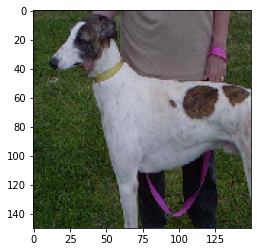

In [ ]:
#returns a batch of images from the test data
x,y=test_generator.next()
#x[0] is the first image in the batch
test_image=x[0]
print(test_image.shape)
plt.imshow(test_image)
plt.show()


Now we can run this image through the network using the <code>predict</code> method. When we call <code>predict</code>, it performs the forward pass on a *batch* of images and compute the output(s) of the network for each image in the batch. 
More specifically, the predict method accepts an input of the shape (batch_size, image_width, image_height, channels). test_image is a single image of shape (image_width, image_height,channels) so we expand its dimension to (1,image_width, image_height,channels) to represent a batch of one image.

In [ ]:
test_image = np.expand_dims(test_image, axis=0)
print(test_image.shape)
activations = activation_model.predict(test_image)
first_layer_activation=activations[0]
print(first_layer_activation.shape)

(1, 150, 150, 3)
(1, 150, 150, 32)


The first convolution layer has 32 channels.  let's view the first channel:

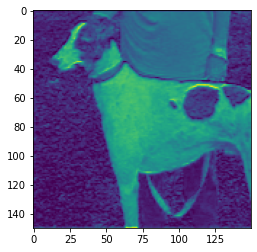

In [ ]:
#The first index is for the image in the batch , the second and third are for image height and width, and the last index is for channel number.
plt.imshow(first_layer_activation[0, :, :, 0])

This channel appears to encode a contrast. Let’s try the 4th channel but note that your own channels may vary, because the specific
filters learned by convolution layers aren’t deterministic. This appear to detect some edges

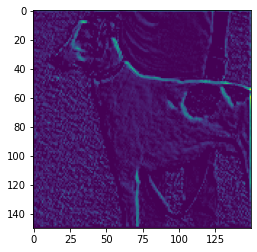

In [ ]:
plt.imshow(first_layer_activation[0, :, :, 3])

We can go ahead and visialize all the activations for each convolution layer using the following code segment. 
The comments in the code segment explain what each line does.

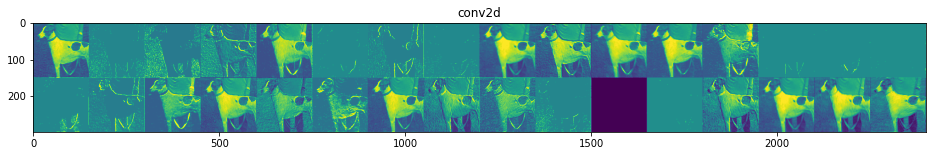

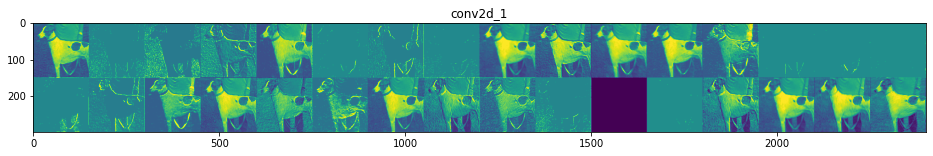

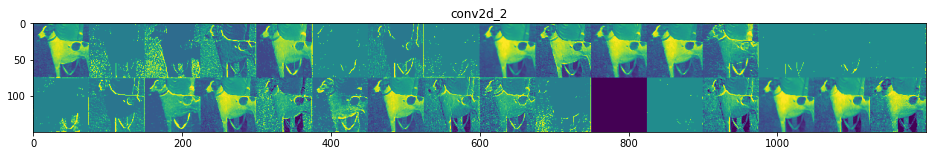

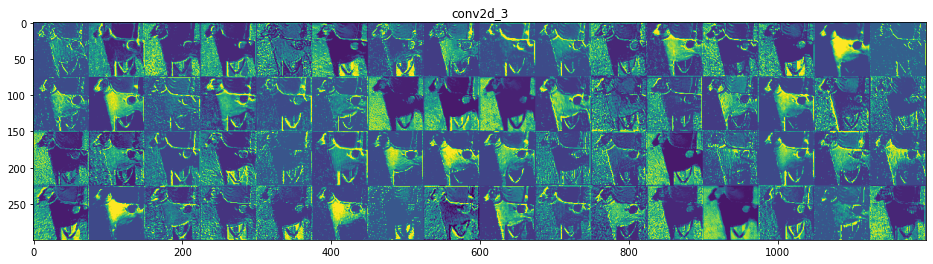

In [ ]:
#name of the layers so you can show them in your plot 
layer_names = []

# We just want to visualize the convolution layers only
for layer in model.layers:
  #get the name of each layer and add it to a layaer_names
  if layer.name.startswith("conv"):
    layer_names.append(layer.name)
  
# Show 15 images per row
images_per_row = 16
    
# Display the feature maps    
for layer_name, layer_activation in zip(layer_names, activations):  #layer_activation has the shape[index_in_the_batch,width, height, channel_numbers 
  #get the number of channels/features ( the last index in activation)
  n_features = layer_activation.shape[-1]
  
  #get the width of the features
  size = layer_activation.shape[1]
  
  #figure out how many rows you need to show all the activations in the layer
  n_cols = n_features // images_per_row
  
  #create a grid to show all the activations for the layer
  display_grid = np.zeros((size * n_cols, images_per_row * size))

  #for each activation/feature
  for col in range(n_cols):
    for row in range(images_per_row):
      
      #post process the feature to make it visually platable
      channel_image = layer_activation[0,:, :,col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')

      #display the activation
      display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image 
  
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

The baseline convolutional network we created is not very deep. In a deeper convetnet, the As you go higher, the activations become increasingly abstract and less visually interpretable. They begin to encode higher-level concepts such as “cat ear” and “cat eye.” Higher presentations carry increasingly less information about the visual contents of the image, and increasingly more information related to the class of the image. 

To verify this, You can modify the above code and try to load and visualize the convolution layers in the fine tuned model

## Visualizing heatmaps of class activations
Visualizing a heatmap of class activations is useful for understanding
which parts of a given image led a convnet to its final classification decision.
The techniques for producing heatmap of class activations over an input image are referred to as *class activation maps (CAM)* .  

class activation heatmap is a 2D grid of scores associated with a specific output class, computed for every location in any input image, indicating how important each location is with respect to the class under consideration.

For instance, given an image fed into a dogs versus 
cats convnet, CAM visualization allows you to generate a heatmap for the class
“cat,” indicating how cat-like different parts of the image are, and also a heatmap for the class “dog,” indicating how dog-like parts of the image are.

This is helpful for debugging the decision process of a convnet, particularly in the case of a classification mistake. It also allows you to locate specific objects in an image.

The method that we use here to compute the class activation map is a gradient based method called "GRAD-CAM" proposed by Selvaraju et. al in [this paper](https://arxiv.org/abs/1610.02391).

Grad-CAM is based on this idea that for a given input image, we can take the gradient of any target class (for instance, cat or dog) flowing back through the last convolution layer to comptue the weight/importance of each channel in that layer.

Intuitively, one way to understand this trick is that you’re
weighting a spatial map of “how intensely the input image activates different channels in the last convolution layer” by “how important each channel in the last convolution layer is with regard to the target class,” resulting in a spatial map of “how intensely the input image activates the class.”

To compute the activation map of a given input image for a given target class in GRADCAM, here is what we need to do:
1. Compute the network output for the input image with regards to a target class ( e.g., dog or cat in this case).
2. Take the output of the target class for which you want to get the activation map and Compute its gradient with respect to the neurons' outputs in the last conv layer
3. multiply the neurons' outputs in each channel of the last conv layer  by the mean of gradients for that channel. You end up with a volumn of size $w\times h\times d$ where $w$ and $h$ are the width and height of the feature map in the last conv layer and $d$ is the number of channels in that layer.  
4. Take the average of the neurons' output over all d channels to end up with a heat map of size $w\times h$ 

5. Project this heat map onto the input image to show what parts of input image the network looked at to arrive at its output with regards to the class under consideration.

Let's implement this in keras. 

First we load our fine tuned model from the disk.

In [ ]:
finetuned_model = load_model('cats-vs-dogs-finetuned.h5')
finetuned_model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 75, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________

Now let's get a cat image in the validation data that is missclassified with a high probability by the fine-tuned model.

True label is cat, CNN predicted dog with confidence 0.8413088321685791


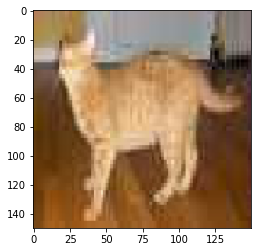

In [ ]:

missclassified_image=None
while missclassified_image is None: 
  x,y=validation_generator.next()
   
  # Get the predicted probabilities for the images in the batch. It will return a numpy array of size 1*batch_size, so flatten it to a vector
  y_pred = finetuned_model.predict(x).flatten()
    
  #get the indices of the missclassified images in the batch
  for i in range(len(y_pred)):
    #find a missclassified cat image with a high probability
    if(y_pred[i]>0.8 and y[i]==0):
      
      #display the missclassified cat image together with their predicted probabilities
      print("True label is cat, CNN predicted dog with confidence {}".format(y_pred[i]))
      plt.imshow(x[i])
      plt.show()
      missclassified_image=x[i]
      break
  
        
    

No we are ready to compute the class activation map ( we call it heatmap) for this image based n the approach in  [Selvaraju et. al in](https://arxiv.org/abs/1610.02391).

This heatmap will tell us which areas of the image are more important in predicting the final target class . If you don't understand every line of the following code segment, it is OK as long as you have a general understanding of how class activation maps are computed. The inline comments below are helpful to understand the code.

The shape of heatmap is (4, 4)


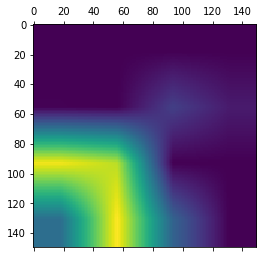

In [ ]:

#getting the output of the last dense layer which is the outpu of the finetuned model
dog_output= finetuned_model.output

#get the output of the last convolutional block.
conv_layer_output= finetuned_model.get_layer("conv5_block16_concat").output

#create a model that gets the input and gives us the output of both the last dense layer and the last convolution layer. We will use this model to compute the gradients
grad_model = tf.keras.Model(inputs=finetuned_model.input, outputs=[conv_layer_output, dog_output])

#convert the missclassigied_image to tensor 
missclassified_image_tensor=tf.cast(missclassified_image, tf.float32)
missclassified_image_tensor=tf.expand_dims(missclassified_image_tensor,0)

'''the gradientTape class allows us to compute the gradient ( it remembers the operations that is performed during forward pass,
 then TensorFlow traverses this list of operations in reverse order to compute gradients.)'''
with tf.GradientTape() as tape: 
  #Pass the missclassified image tensor to grad_model to compute the output of the last conv layer (conv_layer_output_value) and the last dense layer (dog_output_value) for this image
  (conv_layer_output_value, dog_output_value)= grad_model(missclassified_image_tensor)  

#use the gradient tape to compute the gradient of dog_output_value with respect to conv_layer_output
grads = tape.gradient(dog_output_value, conv_layer_output_value)

# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
conv_layer_output_value=conv_layer_output_value[0]
grads=grads[0]

#Take the mean of gradients over each channel. This basically computes the importance of that channel
channel_importance = tf.reduce_mean(grads, axis=(0, 1))



#multiply each channel in the output of last convolution layer by that channel's importance and get the mean over all channels to create the heatmap
heatmap= tf.reduce_mean(tf.multiply(channel_importance, conv_layer_output_value), axis=-1)

#convert the heatmap from tensor to numpy
heatmap=heatmap.numpy()

#scale the heatmap by dividing it by its max value
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
print("The shape of heatmap is {}".format(heatmap.shape))


#heatmap has the same size as the last convolution layer (that is 4*4). So let's resize the heat map to have the same size as the original image
heatmap = cv2.resize(heatmap, (missclassified_image.shape[1], missclassified_image.shape[0]))

#display the heatmap
plt.matshow(heatmap)

The brighter spots in the heatmap correspond to larger activations in the last convolution layer. 

To see where these spots are in the original image, we need to overlay the heatmap on the  image. We can use OpenCV lirbary to generate an image that superimposes the original image on the heatmap. This will help us visualize where, in the original image, the network is focusing on to predict the dog class.





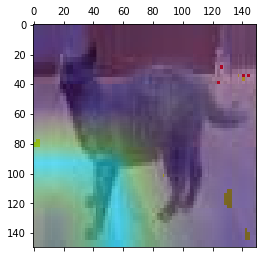

In [ ]:
# convert both the heatmap and original image to unsighed 8-bit integer arrays
heatmap = (heatmap * 255).astype("uint8")
missclassified_image=(missclassified_image * 255).astype("uint8")

'''In order to overlay the heatmap, we first need to apply a pseudo/false-color to the heatmap. 
To do so, we will use OpenCV’s built in VIRIDIS colormap (i.e., cv2.COLORMAP_VIRIDIS).
With this color map, the ligher values int he heatmap will map to a light green or yellow
''''
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_VIRIDIS)

#Now overlay the heatmap on the original image
output = cv2.addWeighted(missclassified_image, 0.5, heatmap, 0.5, 0)

#display the overlaid image
plt.matshow(output)

looks like our network is mostly looking at the front leg area on this picture to decide  that it is a dog. You can rerun the above three code cells to get a different cat image missclassified as a dog and check out its heatmap.